fase de clasificacion supervisada: preparar cuadernillos con los experimentos, explicar modelos utilizados (reg log, random forest ... cnn), comparar rendimiendo y buscar formas para mejorar

Una vez obtenido un dataset con suficientes noticias de cada categoria objetivo, procedimos a realizar los primeros entrenamientos de distintos modelos de clasificacion supervisada, contemplando tambien una fase de preprocesamiento de la entrada para mejorar en algunos aspectos y simplificar otros...

# Preprocesamiento

## Titulo y cuerpo de la noticia

Como se comento en pasos anteriores, el titulo de una noticia es de gran importancia ya que concentra una gran cantidad de informacion, por lo que es una buena idea incluirlo dentro de los datos con los que se entrenaran nuestros modelos. El dataset contiene una columna 'content' en el que se encuentra el titulo de la noticia mas el cuerpo 

...

In [1]:
import pandas as pd
from pandasql import sqldf

In [2]:
ds_names = ['dataset_paso_3.csv',  # original
            'dataset_paso3d5.csv', # + cultura y planeta
            'dataset_paso3d8.csv', # + cultura 
            'dataset_paso3d9.csv'] # + planeta (sin mucho cambio)
MAX_LEN = 2000
RANDOM_STATE = 8008
df = pd.read_csv(ds_names[0])
#df = pd.read_csv('dataset_paso_3.csv')
pd.set_option('display.max_colwidth', 200)
df[['title', 'content']].head()

,title,content
0,"Vacunación en Chile empezaría primer trimestre del 2021 e incluiría a 15,2 millones de personas","Vacunación en Chile empezaría primer trimestre del 2021 e incluiría a 15,2 millones de personas. Este martes, el Presidente Sebastián Piñera anunció que el plan de vacunación para combatir el cor..."
1,"Sernapesca: ""Viabilidad del virus de infectar es muy baja"" tras hallazgo de COVID-19 en paquete chileno en China","Sernapesca: ""Viabilidad del virus de infectar es muy baja"" tras hallazgo de COVID-19 en paquete chileno en China. La aduana china detectó la presencia del virus COVID-19 en la superficie de una ca..."
2,"Presidente de México asegura que la pandemia ""no nos ha rebasado""","Presidente de México asegura que la pandemia ""no nos ha rebasado"". El presidente de México, Andrés Manuel López Obrador, afirmó que su gobierno ha logrado controlar la pandemia del nuevo coronavir..."
3,Gobierno de Uruguay endurece medidas por aumento sostenido de casos de covid-19,"Gobierno de Uruguay endurece medidas por aumento sostenido de casos de covid-19. El presidente de Uruguay, Luis Lacalle Pou, anunció este martes nuevas medidas para contener el avance de la pandem..."
4,Presidente boliviano destituye a ministro que contrató a su expareja,"Presidente boliviano destituye a ministro que contrató a su expareja. El presidente boliviano, Luis Arce, destituyó este martes a un ministro que contrató como su brazo derecho a una expareja, a q..."


In [3]:
_df = df.groupby(['category']).size().sort_values()
_df

category
6-Cultura_y_Artes               795
8-Ecología_y_Planeta            863
5-Catástrofes_y_Accidentes     1245
2-Economía                     2636
10-Salud                       2690
4-Ciencias_y_Tecnología        4778
7-Deporte                      6708
9-Crimen_delitos_y_Justicia    8213
1-Mundo                        8609
3-Política_y_Conflictos        8977
dtype: int64

In [4]:
SAMPLE_SIZE = _df[0]
SAMPLE_SIZE

795

# balancear el dataset alan tigua?
## Exportar dataset balanceado para el siguiente paso

In [5]:
FORCE_BALANCE = True
if FORCE_BALANCE:
    new_df = df.groupby('category').sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE)
    new_df.reset_index(drop=True, inplace=True)
    new_df.to_csv(f'ds_balanced_{SAMPLE_SIZE}_rs{RANDOM_STATE}.csv', index=False)
else:
    new_df = df
new_df.head(5)

,id,title,content,category
0,615763,Vacuna de Oxford y AstraZeneca muestra 70% de eficacia en ensayos clínicos,Vacuna de Oxford y AstraZeneca muestra 70% de eficacia en ensayos clínicos. El laboratorio británico AstraZeneca y la universidad de Oxford indicaron este lunes en un comunicado conjunto que la va...,1-Mundo
1,6639694,Cruel asesinato en Rusia: Abuelos dan muerte a su pequeño nieto solo por llorar,"Cruel asesinato en Rusia: Abuelos dan muerte a su pequeño nieto solo por llorar. Un terrible asesinato mantiene consternado a los habitantes del distrito Kuybyshevsky de Novokuznetsk, Rusia, espec...",1-Mundo
2,5723544,Alemania se muestra preocupada por “situación muy explosiva” en recuento de votos en EE.UU.,"Alemania se muestra preocupada por “situación muy explosiva” en recuento de votos en EE.UU.. Alemania está preocupada por una “situación muy explosiva” en Estados Unidos, donde Donald Trump se dec...",1-Mundo
3,621277,"UE concluye que Reino Unido debe aplicar Acuerdo de retirada del Brexit ""y punto final""","UE concluye que Reino Unido debe aplicar Acuerdo de retirada del Brexit ""y punto final"". Los líderes de los 27 países de la UE consideran que el Reino Unido debe aplicar el Acuerdo de Retirada tal...",1-Mundo
4,5752823,Argentina supera los 461 mil contagiados de Covid-19: Suma más de 10 mil casos nuevos y 262 muertos en el último balance,Argentina supera los 461 mil contagiados de Covid-19: Suma más de 10 mil casos nuevos y 262 muertos en el último balance. La pandemia del nuevo coronavirus originado en la ciudad china de Wuhan ha...,1-Mundo


In [6]:
new_df.groupby(['category']).size().sort_values()

category
1-Mundo                        795
10-Salud                       795
2-Economía                     795
3-Política_y_Conflictos        795
4-Ciencias_y_Tecnología        795
5-Catástrofes_y_Accidentes     795
6-Cultura_y_Artes              795
7-Deporte                      795
8-Ecología_y_Planeta           795
9-Crimen_delitos_y_Justicia    795
dtype: int64

## Truncar contenido


habria que probar si esto mejora los pasos anteriores (lda) xd

In [7]:
lol = df.content.map(len).idxmax()
df.iloc[lol].content # ?????

'Chile: El plebiscito amenazado.  “Los guerreros victoriosos ganan primero y luego van a la guerra, mientras que los guerreros derrotados van a la guerra primero y luego buscan ganar” Sun Tzu 1.-Resumen Ante el próximo plebiscito por una nueva constitución, se analiza y evalúa la actual ofensiva de parte de la derecha para su neutralización. Se busca evitar la opción de Piñera de no realizar el plebiscito, haciendo del apruebo un consenso de gobierno y oposición, generando una situación en que todos estamos por el apruebo, evitando así el triunfo del progresismo y la ciudadanía. Por Alejandro Navarro Brain 2.- Escenarios de la votación para el 25 de octubre 2.1.- Alta participación y alta diferencia de votos 2.2.- Alta participación y baja diferencia de votos 2.3.- Baja participación y alta diferencia de votos 2.4.- Baja participación y baja diferencia de votos. 3.- Estrategias de campaña de la derecha en el plebiscito 3.1.-Pandemia, miedo y abstención: Con la situación de la pandemia,

## Cuanto truncar??

### Por caracteres o por palabras? asegurarse de que la ultima palabra no se corte?

In [8]:

df['content'] = df.content.str.slice(0, MAX_LEN)

In [9]:
print('min len: ', df.content.map(len).min())
print('max len: ', df.content.map(len).max())

min len:  184
max len:  800


## Bag of words + tf-idf

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

## NLTK

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize.casual import casual_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import plot_confusion_matrix, classification_report
#from sklearn.pipeline import Pipeline
from functools import partial

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib notebook
from functools import partial
import numpy as np

from string import punctuation
import re
from tqdm.auto import tqdm
from spacy.lang.es import Spanish
import string
import spacy

In [12]:
#nltk.download('stopwords')
#nltk.download('punkt')

In [13]:
#stopwords
spanish_stopwords = stopwords.words('spanish')

#stemmer
stemmer = SnowballStemmer('spanish')

#puntuacion
non_words = list(punctuation)
#incluir puntuacion del español
non_words.extend(['¿', '¡'])
#numeros
non_words.extend(map(str,range(10)))

# Incluir n-grams?

In [14]:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def text_cleaner(text, stem=False):
    # puntuacion
    text = ''.join([c for c in text if c not in non_words])
    # caracteres repetidos, skippeable
    text = re.sub(r'(.)\1+', r'\1\1', text)
    # tokenize
    tokens = casual_tokenize(text, preserve_case=False)
    # quitar stopwords
    filtered_sentence = [w for w in tokens if not w in spanish_stopwords]
    # stemming
    if stem:
        filtered_sentence = stem_tokens(filtered_sentence, stemmer)
    
    return " ".join(filtered_sentence)

In [15]:
train_size = 0.70

In [16]:
train_idxs = new_df.groupby('category').sample(frac=train_size, random_state=RANDOM_STATE).index
train_df = new_df.iloc[train_idxs]
q="""SELECT category, count(*) FROM train_df GROUP BY category ORDER BY count(*) DESC;"""
result=sqldf(q)
result

,category,count(*)
0,9-Crimen_delitos_y_Justicia,556
1,8-Ecología_y_Planeta,556
2,7-Deporte,556
3,6-Cultura_y_Artes,556
4,5-Catástrofes_y_Accidentes,556
5,4-Ciencias_y_Tecnología,556
6,3-Política_y_Conflictos,556
7,2-Economía,556
8,10-Salud,556
9,1-Mundo,556


In [17]:
test_idxs = pd.concat([new_df, train_df]).drop_duplicates(keep=False).index
test_df = new_df.iloc[test_idxs]
q="""SELECT category, count(*) FROM test_df GROUP BY category ORDER BY count(*) DESC;"""
result=sqldf(q)
result

,category,count(*)
0,9-Crimen_delitos_y_Justicia,239
1,8-Ecología_y_Planeta,239
2,7-Deporte,239
3,6-Cultura_y_Artes,239
4,5-Catástrofes_y_Accidentes,239
5,4-Ciencias_y_Tecnología,239
6,3-Política_y_Conflictos,239
7,2-Economía,239
8,10-Salud,239
9,1-Mundo,239


In [18]:
lb = LabelEncoder()
ylabels = new_df['category']
# unique_labels = sorted(ylabels.unique(), key=lambda x : len(x.split('-')[0]))
lb.fit(ylabels.unique())
true_labels = [lb.inverse_transform([i])[0] for i in range(ylabels.nunique())]
ylabels_train_target = lb.fit_transform(ylabels[train_idxs])
ylabels_test_target = lb.fit_transform(ylabels[test_idxs])

# tendriamos que hacer zfill para que queden ordenadas (01-mundo, 02- economia)
# o quitar el numero y ya xd
for label in true_labels:
    print(f" {label:<12} :  {lb.transform([label])[0]}")

 1-Mundo      :  0
 10-Salud     :  1
 2-Economía   :  2
 3-Política_y_Conflictos :  3
 4-Ciencias_y_Tecnología :  4
 5-Catástrofes_y_Accidentes :  5
 6-Cultura_y_Artes :  6
 7-Deporte    :  7
 8-Ecología_y_Planeta :  8
 9-Crimen_delitos_y_Justicia :  9


In [19]:
from spacy.lang.es.stop_words import STOP_WORDS

nlp = spacy.load('es_core_news_md', disable=['parser','ner','textcat','...'] )
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
# nlp = spacy.load("es_core_news_md")
stop_words = STOP_WORDS

stemmer = SnowballStemmer('spanish')

# Creating our tokenizer function
def spacy_tokenizer(sentence, stem=False):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens]
    
    # Removing stop words, ver lo de puntuuacion con  token.tag_
    mytokens = [ word for word in mytokens 
                          if word not in stop_words 
                          and word not in punctuations ]
    if stem:
        mytokens = [ stemmer.stem(word) for word in mytokens ]
    # return preprocessed list of tokens
    return " ".join(mytokens)

In [20]:
contento = new_df.content[5]
print(len(contento))
contento

3308


'Trump da luz verde a proceso de transición a la administración de Joe Biden, pero sigue sin reconocer derrota. El  presidente saliente de EE.UU., Donald Trump , indicó este lunes que daba luz verde a la transferencia de poder al  demócrata Joe Biden , ganador de los comicios presidenciales,  aunque sigue sin reconocer su derrota. "Quiero agradecer a Emily Murphy en GSA (la Administración General de Servicios) por su firme dedicación y lealtad a nuestro país. Ha sido acosada, amenazada y objeto de abusos -y no quiero ver que esto le pasa a ella, su familia o a empleados de GSA. Nuestro caso continúa FUERTEMENTE, seguiremos la buena lucha y creo que prevaleceremos", tuiteó Trump. "Sin embargo -siguió-, en el mejor interés de nuestro país, r ecomiendo que Emily y su equipo hagan lo que tengan que hacer respecto a los protocolos iniciales,  y le he dicho a mi equipo que haga lo mismo". Desde que el triunfo de Biden en las elecciones fuera proyectado por los medios de comunicación el pasad

In [21]:
#%%timeit
#text_cleaner(contento)

In [22]:
#%%timeit
# bastante mas lento que el otro, tal vez hay que deshabilitar mas cosas
#spacy_tokenizer(contento)

In [23]:
text_cleaner(contento)

'trump da luz verde proceso transición administración joe biden sigue reconocer derrota presidente saliente eeuu donald trump indicó lunes daba luz verde transferencia poder demócrata joe biden ganador comicios presidenciales aunque sigue reconocer derrota quiero agradecer emily murphy gsa administración general servicios firme dedicación lealtad país sido acosada amenazada objeto abusos quiero ver pasa familia empleados gsa caso continúa fuertemente seguiremos buena lucha creo prevaleceremos tuiteó trump embargo siguió mejor interés país r ecomiendo emily equipo hagan hacer respecto protocolos iniciales dicho equipo haga mismo triunfo biden elecciones proyectado medios comunicación pasado noviembre trump reconocido derrota alegado fraude electoral ofrecer pruebas relacionadasdetalle abogados presentado varios pleitos claves tribunales ido desestimando mayoría anuncio trump produjo después diera conocer carta enviada lunes murphy biden certificaba victoria reconocimiento parte gsa trám

In [24]:
spacy_tokenizer(contento)

"trump luz verde a proceso transición a administración joe biden seguir reconocer derrota presidente saliente ee.uu. donald trump indicar lunes luz verde a transferencia demócrata joe biden ganador comicio presidencial seguir reconocer derrota querer agradecer a emily murphy gsa administración servicios firme dedicación y lealtad a país acosar amenazado y objeto abuso -y querer pasar a familia o a empleado gsa caso continúar fuertemente seguir lucha y creer prevaleceremo tuitear trump -siguió- interés país r ecomeir emily y equipo a protocolo inicial y a equipo triunfo biden elección proyectar comunicación 7 noviembre trump reconocer derrota y alegar fraude electoral ofrecer prueba relacionadasdetalle('1004696','1004547 abogado presentar pleito claves tribunal desestimar mayoría anuncio trump producir a carta enviado lunes murphy a biden certificar victoria reconocimiento gsa trámite imprescindible biden acceso a recurso clave a cabo transición gobernar misiva administradora gsa señala

In [25]:
%%time
# usar spacy_tokenizer aca aumenta bastante el tiempo de ejecucion
vectorizer = TfidfVectorizer(preprocessor=partial(text_cleaner, stem=False))
XD = vectorizer.fit_transform(new_df['content'])
feature_names = vectorizer.get_feature_names_out()
X_train = XD[train_idxs]
X_test = XD[test_idxs]

CPU times: user 38.8 s, sys: 87.6 ms, total: 38.9 s
Wall time: 39 s


In [26]:
lgr = LogisticRegression(random_state=RANDOM_STATE, multi_class='ovr', class_weight=None)
lgr.fit(X_train, ylabels_train_target)

LogisticRegression(multi_class='ovr', random_state=33)

In [27]:
#ver efectos de los hiperparametros
rfc = RandomForestClassifier(n_estimators=100, max_depth=100,
              random_state=RANDOM_STATE, criterion='gini', class_weight=None,
              max_features='sqrt', verbose=0)
rfc.fit(X_train, ylabels_train_target)

RandomForestClassifier(max_depth=100, max_features='sqrt', random_state=33)

In [28]:
from my_funcs import results, plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Resultados clasificación
LogisticRegression


                             precision    recall  f1-score   support

                    1-Mundo       0.73      0.85      0.79       239
                   10-Salud       0.34      0.39      0.36       239
                 2-Economía       0.70      0.85      0.77       239
    3-Política_y_Conflictos       0.33      0.33      0.33       239
    4-Ciencias_y_Tecnología       0.75      0.86      0.80       239
 5-Catástrofes_y_Accidentes       0.22      0.16      0.19       239
          6-Cultura_y_Artes       0.58      0.54      0.56       239
                  7-Deporte       0.96      0.98      0.97       239
       8-Ecología_y_Planeta       0.41      0.41      0.41       239
9-Crimen_delitos_y_Justicia       0.27      0.16      0.20       239

                   accuracy                           0.56      2390
                  macro avg       0.53      0.56      0.54      2390
               weighted avg       0.53      0.56      0

<IPython.core.display.Javascript object>


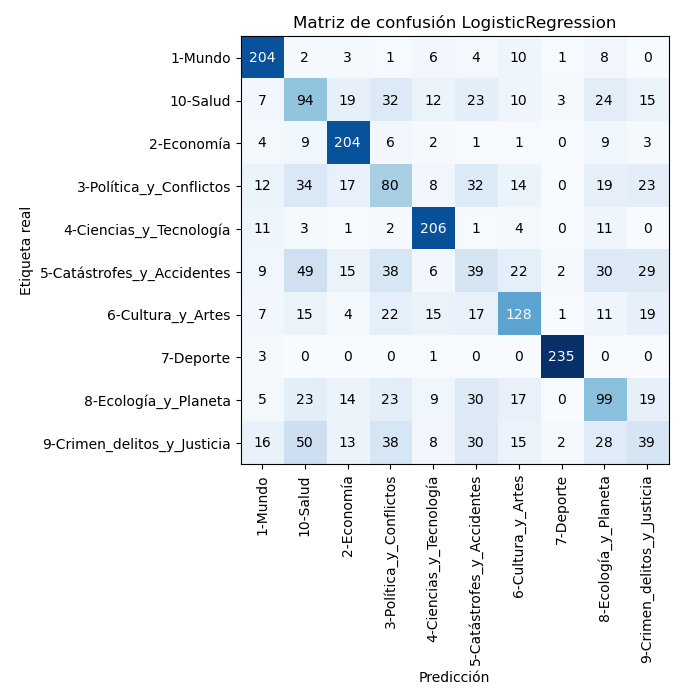

In [32]:
results(ylabels_test_target, lgr, X_test, true_labels)

Resultados clasificación
RandomForestClassifier


                             precision    recall  f1-score   support

                    1-Mundo       0.66      0.85      0.74       239
                   10-Salud       0.26      0.27      0.26       239
                 2-Economía       0.64      0.88      0.74       239
    3-Política_y_Conflictos       0.33      0.29      0.31       239
    4-Ciencias_y_Tecnología       0.69      0.81      0.74       239
 5-Catástrofes_y_Accidentes       0.21      0.16      0.18       239
          6-Cultura_y_Artes       0.56      0.53      0.54       239
                  7-Deporte       0.89      0.99      0.94       239
       8-Ecología_y_Planeta       0.36      0.35      0.36       239
9-Crimen_delitos_y_Justicia       0.16      0.08      0.10       239

                   accuracy                           0.52      2390
                  macro avg       0.48      0.52      0.49      2390
               weighted avg       0.48      0.52   

<IPython.core.display.Javascript object>


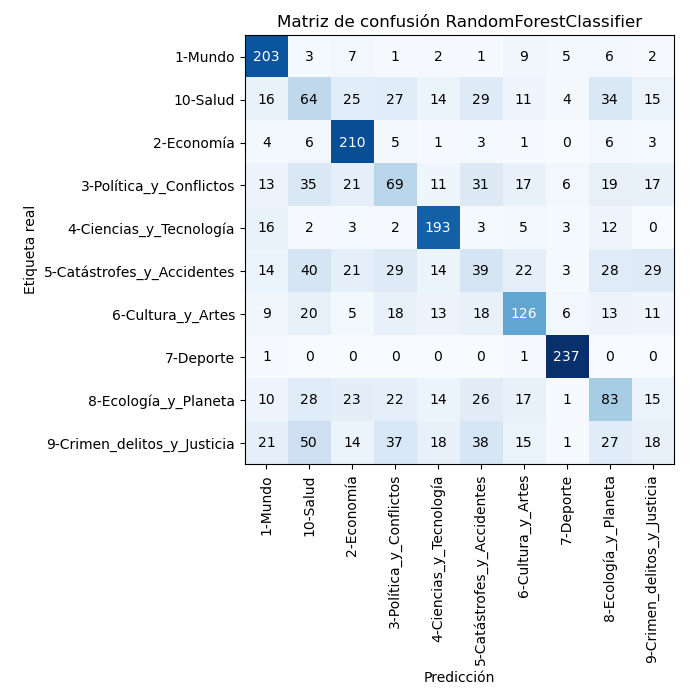

In [33]:
results(ylabels_test_target, rfc, X_test, true_labels)

In [31]:
freno()

NameError: name 'freno' is not defined

# comparar rendimiento usando spacy_tokenizer

In [ ]:
%%time
vectorizer = TfidfVectorizer(preprocessor=partial(spacy_tokenizer, stem=False))
XD = vectorizer.fit_transform(new_df['content'])
feature_names = vectorizer.get_feature_names()
X_train = XD[train_idxs]
X_test = XD[test_idxs]

In [ ]:
%%time
lgr = LogisticRegression(random_state=42, multi_class='ovr', class_weight=None)
lgr.fit(X_train, ylabels_train_target)

In [ ]:
%%time
rfc = RandomForestClassifier(n_estimators=100, max_depth=100,
              random_state=42, criterion='gini', class_weight=None,
              max_features='sqrt', verbose=0)
rfc.fit(X_train, ylabels_train_target)

In [ ]:
results(ylabels_test_target, lgr, X_test, true_labels)

# rfc anda mejor con spacy_tokenizer

In [ ]:
results(ylabels_test_target, rfc, X_test, true_labels)

# cnn

In [ ]:
new_df

In [ ]:
from sklearn.utils import shuffle
new_df = shuffle(new_df)

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.45, random_state=42)
for train_index, test_valid_index in split.split(new_df, new_df.category):
    train = new_df.iloc[train_index]
    test_valid_set = new_df.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.75, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set.category):
    test = test_valid_set.iloc[test_index]
    valid = test_valid_set.iloc[valid_index]



#valid, test, train = np.split(new_df, [ int(.15*len(new_df)), int(.3*len(new_df))] )

In [ ]:
print(new_df.shape)
print(train.shape)
print(valid.shape)
print(test.shape)

In [ ]:
display(train.groupby(['category']).size())
display(valid.groupby(['category']).size())
display(test.groupby(['category']).size())

In [ ]:
test.category.unique()

In [ ]:
train.to_csv("CNN_train.csv", encoding="UTF-8",index=False)
valid.to_csv("CNN_valid.csv", encoding="UTF-8",index=False)
test.to_csv("CNN_test.csv", encoding="UTF-8",index=False)

In [ ]:
import torch
import spacy
import random
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.legacy import data

In [ ]:
spacy_es = spacy.load('es_core_news_sm')

In [ ]:
def tokenize_es(sentence):
    return [tok.text for tok in spacy_es.tokenizer(sentence)]

In [ ]:
TEXT = data.Field(tokenize=tokenize_es, batch_first = True)
CATEGORY = data.LabelField()  # MULTICLASS -se borró el argumento "(dtype = torch.float)"

In [ ]:
CATEGORY

In [ ]:
fields = [(None, None),(None, None),('content', TEXT),('category', CATEGORY)]

In [ ]:
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = '.',
                                        train = 'CNN_train.csv',
                                        validation= 'CNN_valid.csv',
                                        test = 'CNN_test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)


In [ ]:
BATCH_SIZE = 32
device = torch.device('cpu')
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
                                                    (train_data, valid_data, test_data), 
                                                    batch_size = BATCH_SIZE, 
                                                    device = device,
                                                    sort_key=lambda x:len(x.category),
                                                    sort_within_batch=False)

In [ ]:
#!wget http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz

In [ ]:
MAX_VOCAB_SIZE = 50000

## TENER VECTORES EN ESPAÑOL
vec = torchtext.vocab.Vectors('glove-sbwc.i25.vec.gz', cache='.')
TEXT.build_vocab(train_data,
                 vectors=vec,
                 max_size=MAX_VOCAB_SIZE,
                 unk_init=torch.Tensor.normal_)


In [ ]:
CATEGORY.build_vocab(train_data)

In [ ]:
cat_map = { v: k for k, v in CATEGORY.vocab.stoi.items()}
cat_map

In [ ]:
print(CATEGORY.vocab.stoi)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        #text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
        
        return self.fc(cat)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = len(CATEGORY.vocab) ##### MULTICLASS ---> la dimensión del output no es 1 (clasificación binaria)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
model = model.to(device)

In [ ]:
OUTPUT_DIM

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss() #MULTICLASS ---> en lugar de .BCEWithLogitsLoss() (Binary Cross Entropy)


criterion = criterion.to(device)

In [ ]:
from tqdm import tqdm
def train(model, iterator, optimizer, criterion, divisor):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in tqdm(iterator, desc='train'):
        
        optimizer.zero_grad()
        
        #print("Tamaño texto de entrada:"+str(batch.body.shape))
        
        predictions = model(batch.content)
        
        #print("Tamaño predecciones de salida:"+str(predictions.shape)) 
        
        #print("Tamaño target:"+str(batch.category.shape)) 
        
        loss = criterion(predictions, batch.category)
        
        acc = categorical_accuracy(predictions, batch.category, divisor)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def categorical_accuracy(preds, y, divisor):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / divisor([y.shape[0]])

In [ ]:
def evaluate(model, iterator, criterion, divisor):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in tqdm(iterator, desc='eval'):

            predictions = model(batch.content)
            
            loss = criterion(predictions, batch.category)
            
            acc = categorical_accuracy(predictions, batch.category, divisor)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)



In [ ]:
from datetime import datetime
from os import remove
print("inicio optimización")

N_EPOCHS = 5 #5

best_valid_loss = float('inf')
m_info = f'len={MAX_LEN}&balance={FORCE_BALANCE}'
last_best = None
OVERWRITE_MODEL_FILE = True
for epoch in range(N_EPOCHS):

    start_time = time.time()
    divisor = torch.FloatTensor if str(device) == 'cpu' else torch.cuda.FloatTensor
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, divisor)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, divisor)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        dt = str(datetime.now()).replace(' ', '_')
        name = f'./CNN_ep{str(epoch+1)}_{m_info}_{dt}.pt'
        torch.save({'epoca': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'Valid_loss': best_valid_loss}, name)
        if OVERWRITE_MODEL_FILE and last_best is not None:
            remove(last_best)
            last_best = name
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


In [ ]:
name

In [ ]:
best_model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

best_model.embedding.weight.data.copy_(pretrained_embeddings)
best_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
best_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
m_name = name

In [ ]:
best_model.load_state_dict(torch.load(m_name, map_location=torch.device('cpu'))['model_state_dict'])

In [ ]:
test_loss, test_acc = evaluate(model, test_iterator, criterion, divisor)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [ ]:
best_model.eval()
prediction_test = []
labels_test=[]
for batch in test_iterator:
    labels_test.append(batch.category.cpu().detach().numpy())
    predictions = best_model(batch.content.cpu()).squeeze(1)
    prediction_test.append(predictions.argmax(dim=1).detach().numpy())
    #print(torch.sigmoid(predictions))
    #rounded_preds = torch.round(torch.sigmoid(predictions))
    #prediction_test.append(rounded_preds.detach().numpy())
    #print(prediction_test)
    
y_true = np.concatenate(labels_test)
y_pred = np.concatenate(prediction_test)

In [ ]:
lbs = list(cat_map.values())
lbs

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
print(classification_report(y_true,
                            y_pred,
                            target_names=lbs,))

In [ ]:
def plot_confusion_matrix(cm, labels, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(7, 7), tight_layout=True)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, "{:,}".format(cm[i, j]), 
                    horizontalalignment="center", verticalalignment="center",
                    color="white" if cm[i, j] > np.amax(cm)/2 else "black")
    ax.set_title("Matriz de confusión")
    tick_marks = np.arange(len(labels))
    plt.yticks(tick_marks, labels)
    plt.xticks(tick_marks, labels, rotation=90)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Predicción')

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

In [ ]:
plot_confusion_matrix(cm, labels=lbs)

In [ ]:
# best_mode.eval()
#best_model.train(mode=False)

In [ ]:
def predict_class(model, sentence, min_len = 4):

    tokenized = [tok.text for tok in spacy_es.tokenizer(sentence)]
    
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    device = 'cpu'
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    preds = model(tensor)
    print(preds)
    max_preds = preds.argmax(dim = 1)
    return max_preds.item()

In [ ]:
noticia = """Sin embargo, estos experimentos se llevaban a cabo en secreto, y cuando otras secciones de Guardian se dieron cuenta, el proyecto se canceló de inmediato."""
cat_map.get(predict_class(best_model, noticia))

In [ ]:
cat_map.get(predict_class(best_model, "golazo del bicho vs villareal"))